# Nassar et al. test
There are multiple things to consider:
1. using $\tanh$ activation instead of ReLu 
2. MNIST instead of CIFAR10

In [1]:
%load_ext autoreload
%autoreload 2

import torch
from torchvision.transforms import ToTensor
from torch.optim import Adam

from context import *
from LocalLearning import Attacks
from LocalLearning import KHModel, HiddenLayerModel, FKHL3, SHLP, SHLP_tanh, ModelFactory
from LocalLearning import Data
from LocalLearning.Trainers import Trainer, CETrainer
from LocalLearning.Regularizers import LpReg, JFReg, SpecReg
from LocalLearning.Statistics import cov_spectrum
from LocalLearning.Attacks import AdversarialAttack, WhiteGaussianPerturbation, FGSM, PGD, AttackTest
from LocalLearning.Experiments import PerturbationExperiment, RandomPerturbationExperiment, FGSMExperiment, PGDExperiment

from pathlib import Path

import numpy as np
from matplotlib import pyplot as plt
plt.style.use(['seaborn-paper', "./PRLDoubleCol.mplstyle"])

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [3]:
TRAIN = True
NO_EPOCHS = 500

In [4]:
# path variables
# model directory
directory = Path("../data/ICLR-rev1/models")
figure_directory = Path("../data/ICLR-rev1/figures")

# model filenames
# khlayer models
model_path = Path("../data/ICLR/models")

khlayer_cifar10_pruned_name = Path("fkhl3_cifar10_pruned_thr.pty")
khlayer_cifar10_name = Path("fkhl3_cifar10.pty")

# vanilla shlp models
shlp_tanh_name = Path("shlp_tanh_mnist.pty")
shlp_relu_name = Path("shlp_relu_mnist.pty")

shlp_tanh_log_name = Path("shlp_tanh_mnist_log.json")
shlp_relu_log_name = Path("shlp_relu_mnist_log.json")

# spectral regularized models
shlp_tanh_specreg_name = Path("shlp_tanh_specreg_mnist.pty")
shlp_relu_specreg_name = Path("shlp_relu_specreg_mnist.pty")

shlp_tanh_specreg_log_name = Path("shlp_tanh_specreg_mnist_log.json")
shlp_relu_specreg_log_name = Path("shlp_relu_specreg_mnist_log.json")

#fn_list = [khmodel_name, shlp_name, shlp_l2_name, shlp_jreg_name, shlp_specreg_name]
#fn_list = [shlp_name, khmodel_name]

# hyper parameters
BATCH_SIZE = 1000

In [5]:
# load the local learning model
state_dict = torch.load(model_path / khlayer_cifar10_pruned_name)
khlayer = FKHL3(state_dict)

khmodel = KHModel(khlayer, no_classes=10)
khmodel.to(device)

In [6]:
# define training and test datasets for training
mnistTrain= Data.LpUnitMNIST(
    root="../data/MNIST",
    train=True,
    transform=ToTensor(),
    #transform=[],
    p=khlayer.pSet["p"],
)

TrainLoader = Data.DeviceDataLoader(
    mnistTrain,# define batch window in the global index coordinates
    device=device,
    batch_size=BATCH_SIZE,
    num_workers=4,
    shuffle=True,
)

mnistTest = Data.LpUnitMNIST(
    root="../data/MNIST",
    train=False,
    transform=ToTensor(),
    #transform=[],
    p=khlayer.pSet["p"],
)

TestLoader = Data.DeviceDataLoader(
    mnistTest,
    device=device,
    batch_size=BATCH_SIZE,
    num_workers=4,
    shuffle=False,
)

/storA/LocalLearning/LocalLearning/src/LocalLearning/Data.py:176: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.dataset.targets = torch.tensor(self.dataset.targets)


In [7]:
shlp_pSet = khmodel.pSet.copy()
shlp_pSet["n"] = 1.0
shlp_pSet["in_size"] = 28**2

# No Regularization

In [8]:
# train the shlp model for comparison
shlp_relu = SHLP(shlp_pSet)
shlp_relu.to(device)

shlp_tanh = SHLP_tanh(shlp_pSet)
shlp_tanh.to(device)
#init_state = shlp.state_dict()
#torch.save(init_state, model_path / shlp_init_name)

In [9]:
def shlp_schedule(epoch):
    if epoch <= 30:
        return 1e-3
    if (epoch <= 90) and (epoch > 30):
        return 5e-4
    if (epoch <= 120) and (epoch > 90):
        return 2e-4
    if (epoch <= 160) and (epoch > 120):
        return 1e-4
    return 1e-5

if TRAIN:
    shlp_relu.train()
    ce_trainer = CETrainer(shlp_relu, learning_rate=1e-4)
    ce_trainer.run(TrainLoader, TestLoader, no_epochs=NO_EPOCHS)
    ce_trainer.save(directory / shlp_relu_name, directory / shlp_relu_log_name)
    
    shlp_tanh.train()
    ce_trainer = CETrainer(shlp_tanh, learning_rate=1e-4)
    ce_trainer.run(TrainLoader, TestLoader, no_epochs=NO_EPOCHS)
    ce_trainer.save(directory / shlp_tanh_name, directory / shlp_tanh_log_name)

  0%|          | 0/500 [00:00<?, ?epoch/s]

  0%|          | 0/500 [00:00<?, ?epoch/s]

In [10]:
shlp_relu_log = Trainer.Logger()
shlp_tanh_log = Trainer.Logger()
shlp_relu_log.load(directory / shlp_relu_log_name)
shlp_tanh_log.load(directory / shlp_tanh_log_name)

Text(0, 0.5, 'Test accuracy')

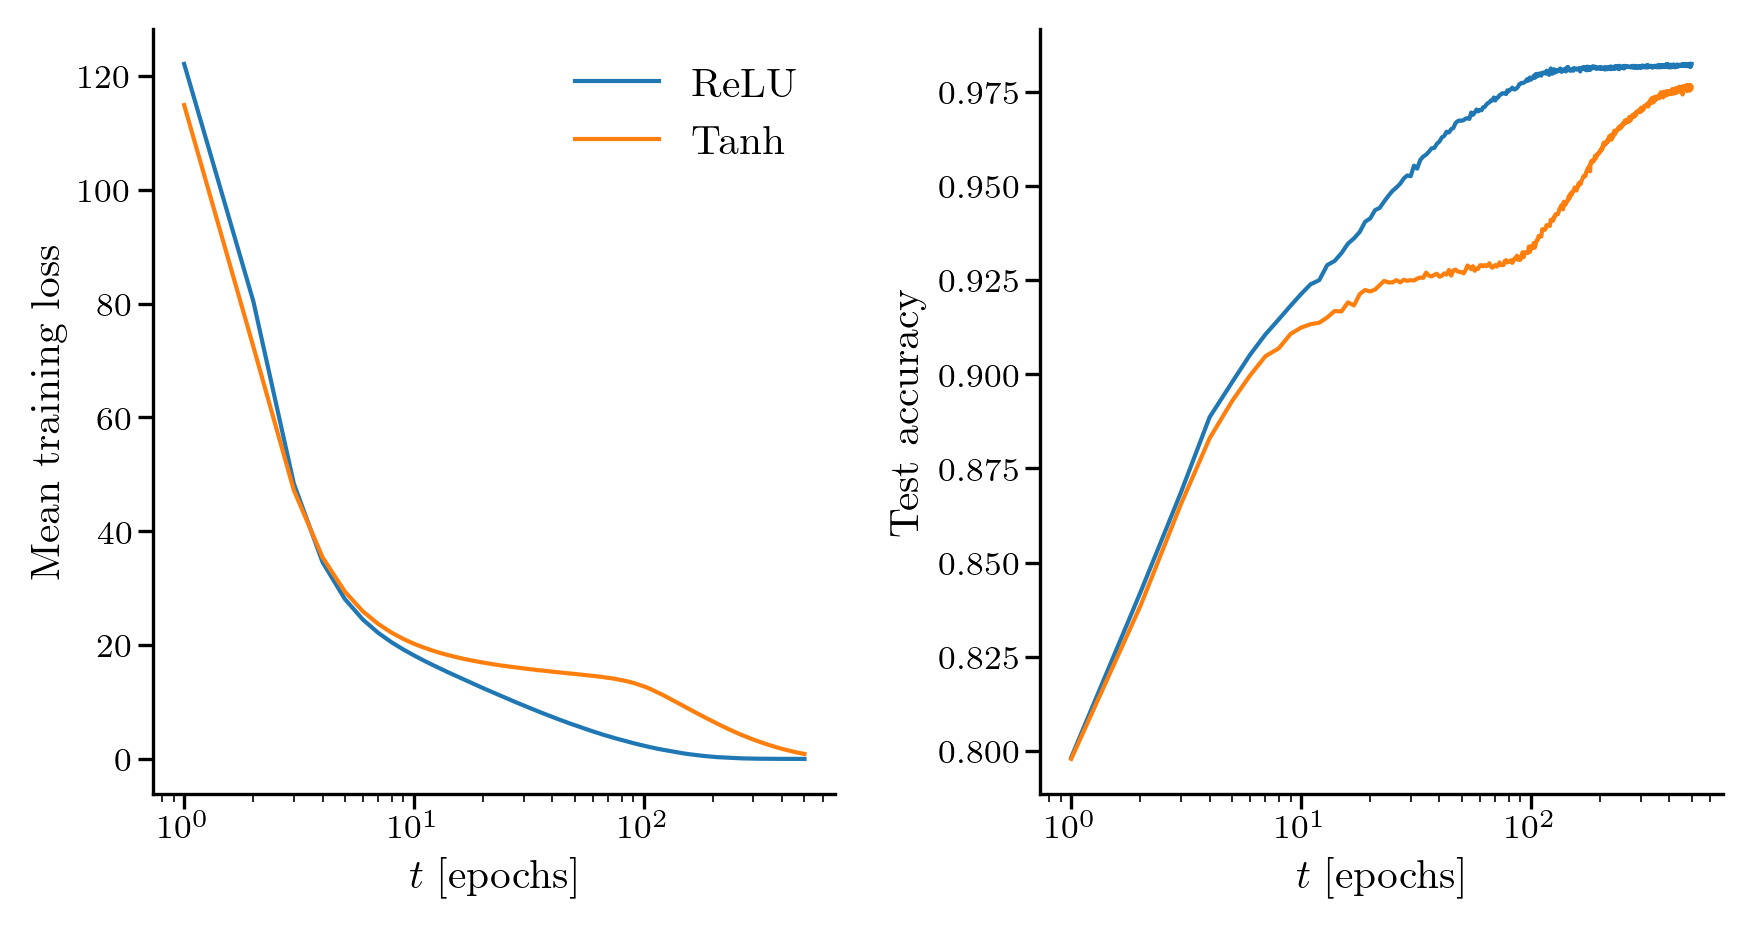

In [11]:
fig, axs = plt.subplots(1, 2)
axs[0].semilogx(shlp_relu_log["epoch"], shlp_relu_log["loss"], label="ReLU")
axs[0].semilogx(shlp_tanh_log["epoch"], shlp_tanh_log["loss"], label="Tanh")
axs[0].set_xlabel(r"$t \; [\textrm{epochs}]$")
axs[0].set_ylabel(r"Mean training loss")
axs[0].legend()

axs[1].semilogx(shlp_relu_log["epoch"], shlp_relu_log["eval_acc"])
axs[1].semilogx(shlp_tanh_log["epoch"], shlp_tanh_log["eval_acc"])
axs[1].set_xlabel(r"$t \; [\textrm{epochs}]$")
axs[1].set_ylabel(r"Test accuracy")

# SpecReg

In [12]:
# train the shlp model for comparison
shlp_relu_specreg = SHLP(shlp_pSet, batch_norm=True)
shlp_relu_specreg.to(device)

shlp_tanh_specreg = SHLP_tanh(shlp_pSet, batch_norm=True)
shlp_tanh_specreg.to(device)

In [13]:
@SpecReg(alpha_SR=1.0, alpha=1.0, tau=0)
@JFReg(alpha_JF=0.0, n=3)
class SpecRegTrainer(CETrainer):
    pass

In [14]:
if TRAIN:
    shlp_relu_specreg.train()
    trainer = SpecRegTrainer(shlp_relu_specreg, learning_rate=1e-4)
    trainer.run(TrainLoader, TestLoader, no_epochs=NO_EPOCHS)
    trainer.save(directory / shlp_relu_specreg_name, directory / shlp_relu_specreg_log_name)
    
    shlp_tanh_specreg.train()
    trainer = SpecRegTrainer(shlp_tanh_specreg, learning_rate=1e-4)
    trainer.run(TrainLoader, TestLoader, no_epochs=NO_EPOCHS)
    trainer.save(directory / shlp_tanh_specreg_name, directory / shlp_tanh_specreg_log_name)
else:
    theFactory = ModelFactory()
    state_dict = torch.load(directory / shlp_relu_specreg_name)
    shlp_relu_specreg = theFactory.build_from_state(state_dict)
    shlp_relu_specreg.to(device)
    
    state_dict = torch.load(directory / shlp_tanh_specreg_name)
    shlp_tanh_specreg = theFactory.build_from_state(state_dict)
    shlp_tanh_specreg.to(device)

  0%|          | 0/500 [00:00<?, ?epoch/s]

  0%|          | 0/500 [00:00<?, ?epoch/s]

In [15]:
log_shlp_relu_specreg = Trainer.Logger()
log_shlp_relu_specreg.load(directory / shlp_relu_specreg_log_name)

log_shlp_tanh_specreg = Trainer.Logger()
log_shlp_tanh_specreg.load(directory / shlp_tanh_specreg_log_name)

In [16]:
l_n_relu_specreg = cov_spectrum(TestLoader, shlp_relu_specreg)
l_n_tanh_specreg = cov_spectrum(TestLoader, shlp_tanh_specreg)

  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/10 [00:00<?, ?batch/s]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, '$\\lambda_{n}$')

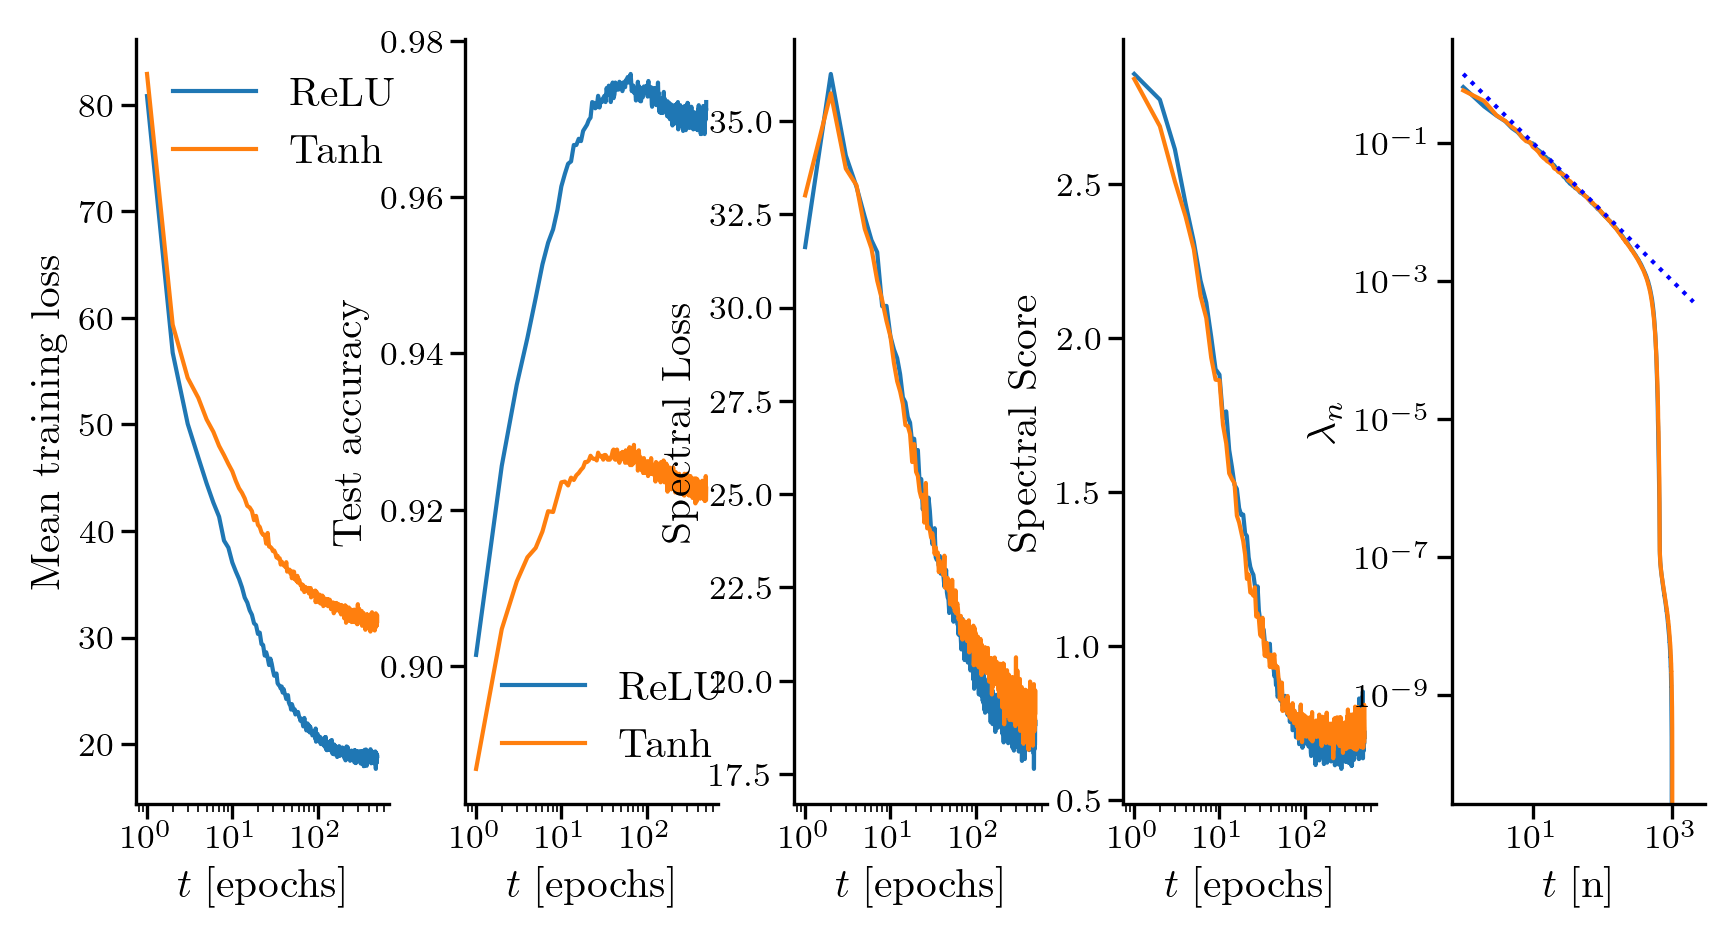

In [17]:
fig, axs = plt.subplots(1, 5)
axs[0].semilogx(log_shlp_relu_specreg["epoch"], np.array(log_shlp_relu_specreg["loss"]), label="ReLU")
axs[0].semilogx(log_shlp_tanh_specreg["epoch"], np.array(log_shlp_tanh_specreg["loss"]), label="Tanh")
axs[0].set_xlabel(r"$t \; [\textrm{epochs}]$")
axs[0].set_ylabel(r"Mean training loss")
axs[0].legend()

axs[1].semilogx(log_shlp_relu_specreg["epoch"], np.array(log_shlp_relu_specreg["eval_acc"]), label="ReLU")
axs[1].semilogx(log_shlp_tanh_specreg["epoch"], np.array(log_shlp_tanh_specreg["eval_acc"]), label="Tanh")
axs[1].set_xlabel(r"$t \; [\textrm{epochs}]$")
axs[1].set_ylabel(r"Test accuracy")
axs[1].legend()

axs[2].semilogx(log_shlp_relu_specreg["epoch"], np.array(log_shlp_relu_specreg["SpecReg_loss"]))
axs[2].semilogx(log_shlp_tanh_specreg["epoch"], np.array(log_shlp_tanh_specreg["SpecReg_loss"]))
axs[2].set_xlabel(r"$t \; [\textrm{epochs}]$")
axs[2].set_ylabel(r"Spectral Loss")
axs[2].legend()

axs[3].semilogx(log_shlp_relu_specreg["epoch"], np.array(log_shlp_relu_specreg["eval_SpecReg_score"]))
axs[3].semilogx(log_shlp_tanh_specreg["epoch"], np.array(log_shlp_tanh_specreg["eval_SpecReg_score"]))
axs[3].set_xlabel(r"$t \; [\textrm{epochs}]$")
axs[3].set_ylabel(r"Spectral Score")

n = np.arange(1, len(l_n_relu_specreg)+1)
l_n_relu_specreg_np = l_n_relu_specreg.detach().cpu().numpy()
l_n_tanh_specreg_np = l_n_tanh_specreg.detach().cpu().numpy()

stringer_n = 1 / n
#l_n_relu_specreg_np /= l_n_relu_specreg_np[10]
#l_n_tanh_specreg_np /= l_n_tanh_specreg_np[10]

axs[4].loglog(n, l_n_relu_specreg_np)
axs[4].loglog(n, l_n_tanh_specreg_np)
axs[4].loglog(n, stringer_n, ":b")
axs[4].set_xlabel(r"$t \; [\textrm{n}]$")
axs[4].set_ylabel(r"$\lambda_{n}$")

# Test Robustness

In [18]:
fn_list = [shlp_tanh_name, shlp_relu_name, shlp_tanh_specreg_name, shlp_relu_specreg_name]

rp_fname = Path("random_perturbation_results.pkl")
fgsm_fname = Path("fgsm_results.pkl")
pgd_fname = Path("pgd_results.pkl")

In [19]:
mnistTest.data = mnistTest.data.detach().cpu().numpy()
mnistTest.targets = mnistTest.targets.detach().cpu().numpy()

In [20]:
ce_loss = torch.nn.CrossEntropyLoss()
eps = np.logspace(-6, np.log(2.5), num=400)

rpE = RandomPerturbationExperiment(ce_loss)
rpE.run(directory, fn_list, mnistTest, eps, device, norm_p=2.0)
rpE.save(directory / rp_fname)

  0%|          | 0/10000 [00:00<?, ?batch/s]

  0%|          | 0/400 [00:00<?, ?perturbation/s]

  0%|          | 0/10000 [00:00<?, ?batch/s]

  0%|          | 0/400 [00:00<?, ?perturbation/s]

  0%|          | 0/10000 [00:00<?, ?batch/s]

  0%|          | 0/400 [00:00<?, ?perturbation/s]

  0%|          | 0/10000 [00:00<?, ?batch/s]

  0%|          | 0/400 [00:00<?, ?perturbation/s]

In [21]:
clrs = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02']
names = ['Tanh', 'ReLU', 'SpecReg Tanh', 'SpecReg ReLU']

def plotPerturbationResults(axs, exp: PerturbationExperiment, names: list, clrs: list) -> tuple:
    crit_norm = []
    left_ax, right_ax = axs
    #fig, axs = plt.subplots(1, 2)
    for i, (key, results) in enumerate(exp):
        left_ax.semilogx(results['eps'], results['acc'], color=clrs[i], label=names[i])
        #crit_eps.append(results['crit_eps'])
        # clean nans from data
        cns_nan = np.isnan(results['crit_eps'])
        crit_norm.append(results['crit_norm'][~cns_nan])
    #axs[1].boxplot(crit_eps, labels=names, showfliers=False)
    right_ax.boxplot(crit_norm, labels=names, showfliers=False)
    left_ax.legend(
        handlelength=0.5,
    )
    left_ax.set_xlabel(r"$\epsilon$")
    left_ax.set_ylabel("Rel. accuracy")
    right_ax.set_ylabel(r"$\| \Delta x \|_{\textrm{crit}}$")
    
    return left_ax, right_ax

(<AxesSubplot:xlabel='$\\epsilon$', ylabel='Rel. accuracy'>,
 <AxesSubplot:ylabel='$\\| \\Delta x \\|_{\\textrm{crit}}$'>)

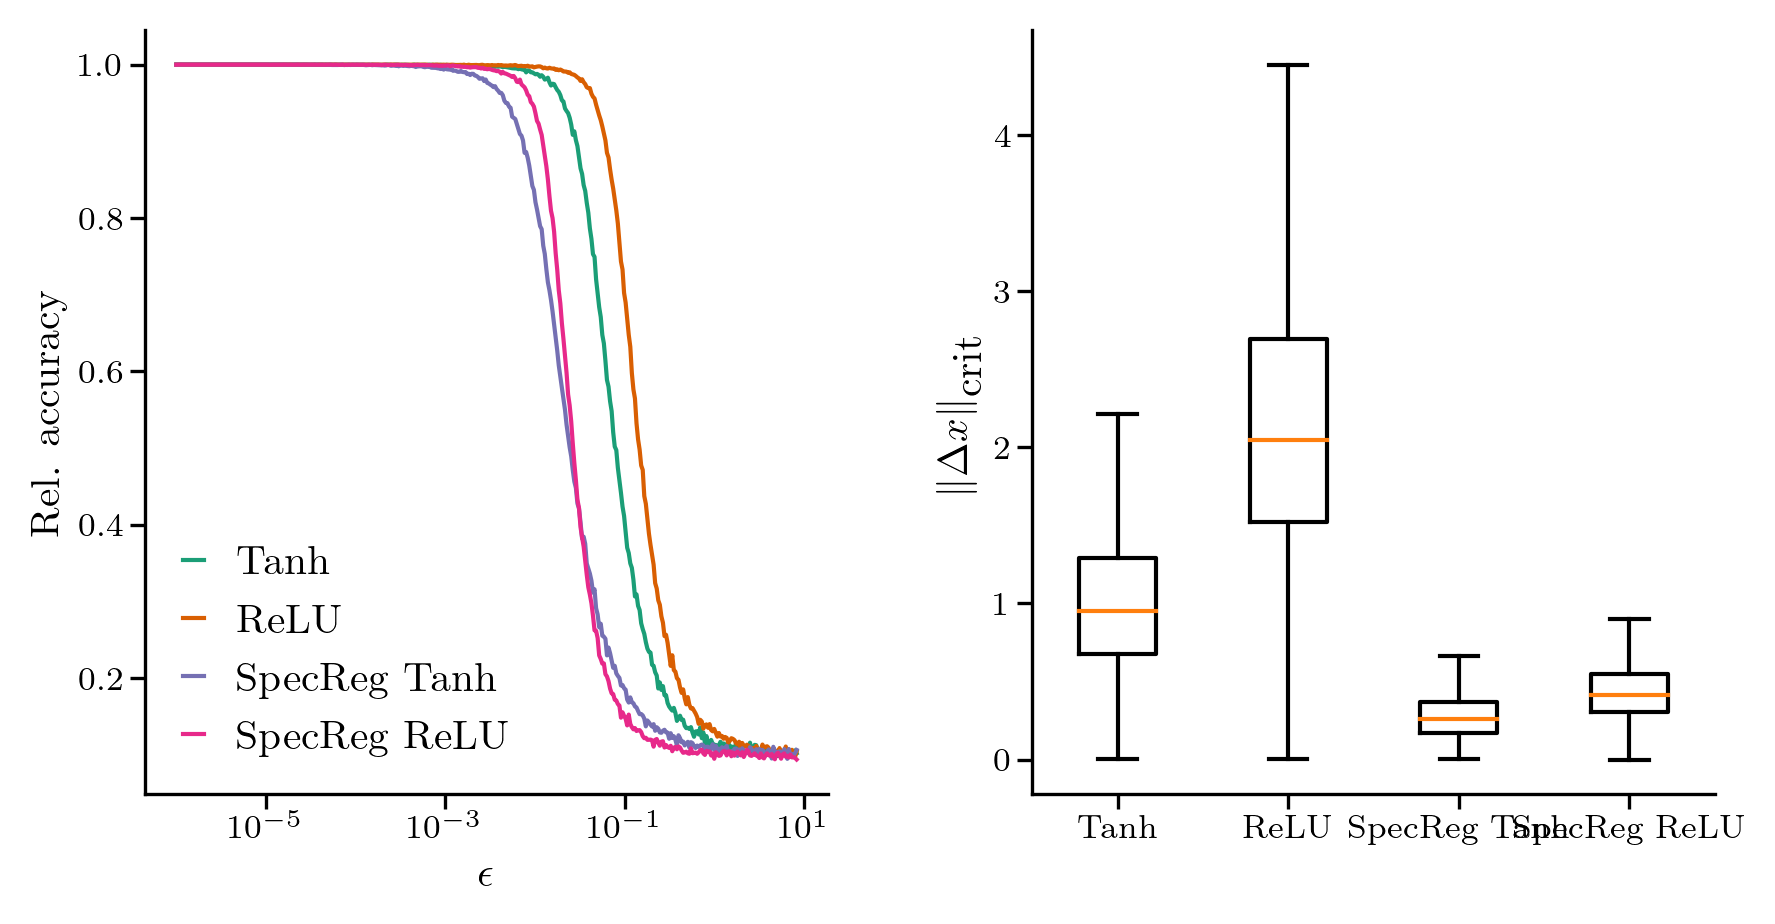

In [22]:
fig, axs = plt.subplots(1, 2)
plotPerturbationResults(axs, rpE, names, clrs)

In [23]:
eps_fgsm = np.logspace(-6, -1, num=400)

fgsmE = FGSMExperiment(ce_loss)
fgsmE.run(directory, fn_list, mnistTest, eps_fgsm, device, norm_p=2.0)
fgsmE.save(directory / fgsm_fname)

  0%|          | 0/10000 [00:00<?, ?batch/s]

  0%|          | 0/400 [00:00<?, ?perturbation/s]

  0%|          | 0/10000 [00:00<?, ?batch/s]

  0%|          | 0/400 [00:00<?, ?perturbation/s]

  0%|          | 0/10000 [00:00<?, ?batch/s]

  0%|          | 0/400 [00:00<?, ?perturbation/s]

  0%|          | 0/10000 [00:00<?, ?batch/s]

  0%|          | 0/400 [00:00<?, ?perturbation/s]

(<AxesSubplot:xlabel='$\\epsilon$', ylabel='Rel. accuracy'>,
 <AxesSubplot:ylabel='$\\| \\Delta x \\|_{\\textrm{crit}}$'>)

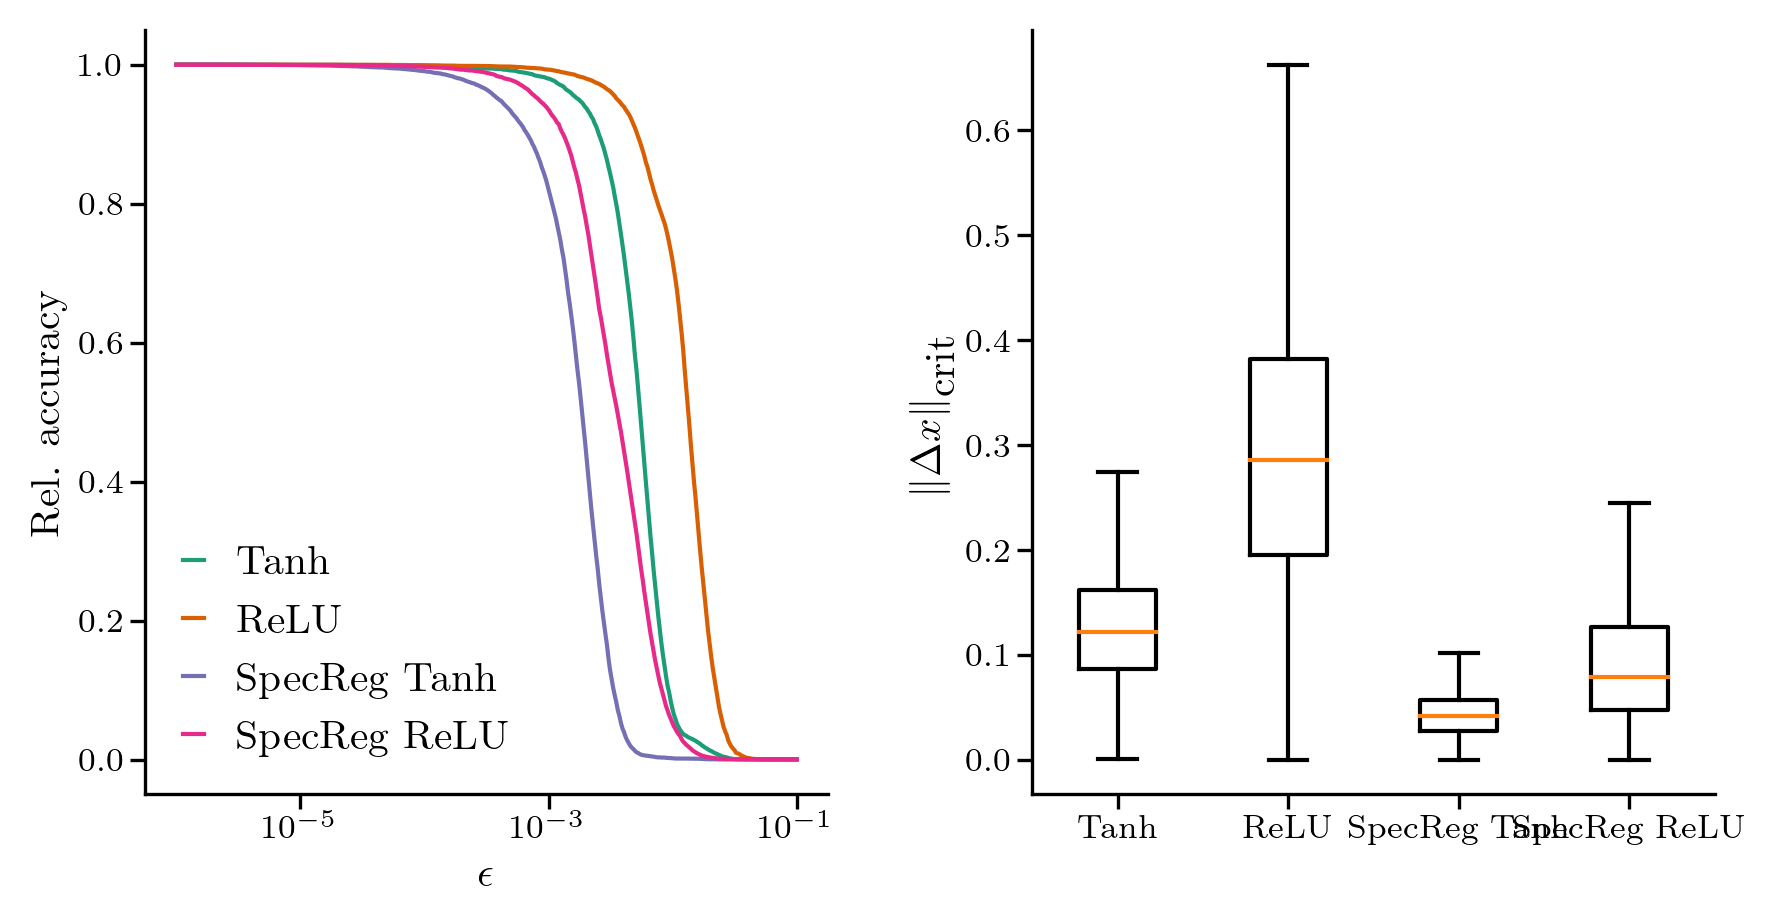

In [24]:
fig, axs = plt.subplots(1, 2)
plotPerturbationResults(axs, fgsmE, names, clrs)

In [25]:
eps_pgd = np.logspace(-6, -1, num=400)

pgdE = PGDExperiment(ce_loss)
pgdE.run(directory, fn_list, mnistTest, eps_pgd, device, norm_p=2.0)
pgdE.save(directory / pgd_fname)

  0%|          | 0/10000 [00:00<?, ?batch/s]

  0%|          | 0/400 [00:00<?, ?perturbation/s]

  0%|          | 0/10000 [00:00<?, ?batch/s]

  0%|          | 0/400 [00:00<?, ?perturbation/s]

  0%|          | 0/10000 [00:00<?, ?batch/s]

  0%|          | 0/400 [00:00<?, ?perturbation/s]

  0%|          | 0/10000 [00:00<?, ?batch/s]

  0%|          | 0/400 [00:00<?, ?perturbation/s]

(<AxesSubplot:xlabel='$\\epsilon$', ylabel='Rel. accuracy'>,
 <AxesSubplot:ylabel='$\\| \\Delta x \\|_{\\textrm{crit}}$'>)

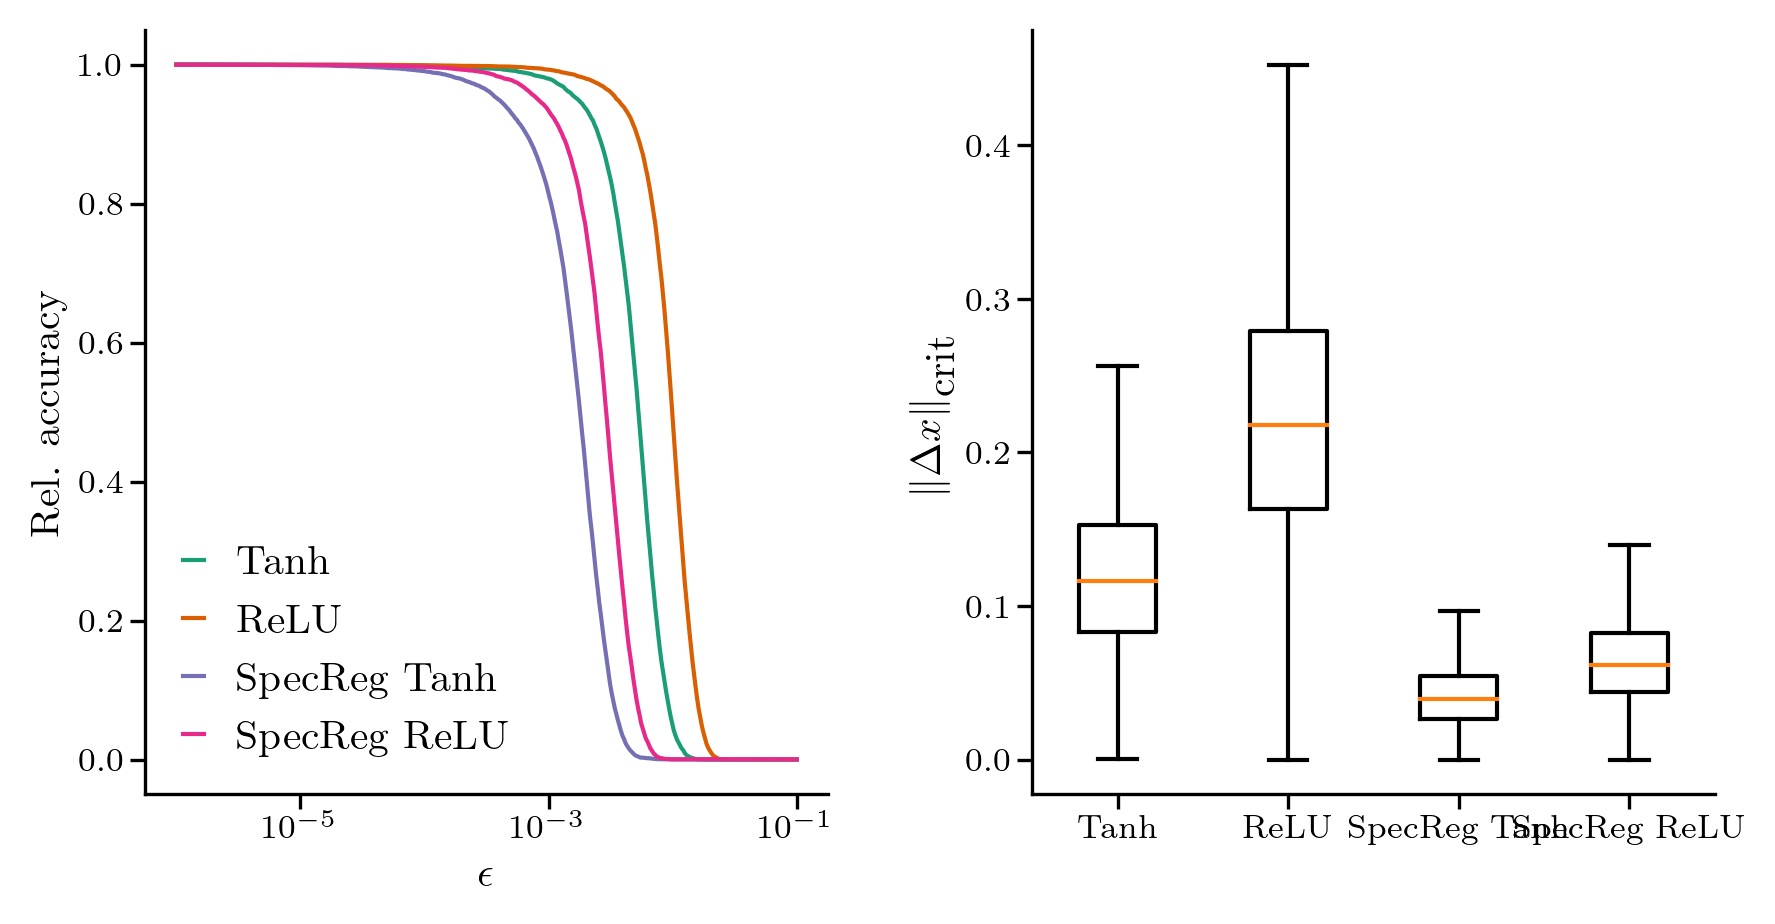

In [27]:
fig, axs = plt.subplots(1, 2)
plotPerturbationResults(axs, pgdE, names, clrs)